<h3>Goals of this project:</h3>
<ul>
    <li>Create an interactive data dashboard to display criminal activity in the City of Sacramento.</li>
    <li>Deploy this interactive dashboard to a simple site via Flask, Heroku(?).</li>
    <li>Create a MySQL database to hold a variety of data related to crime (demographic, etc).</li>
    <li>Implement a ML algorithm to predict future crime on a day-by-day basis.</li>
</ul>
Initially was missing the 2018 dataset, but the City of Sacramento pulled through and provided it!

Would also like to research factors related to crime (weather?) and incorporate more data based on that. Academic papers, etc.

---

<h2>Section 1: Importing, Reviewing, & Cleaning Data</h2>

In [14]:
import pandas as pd
import geopandas as gpd
import folium
import numpy as np
import matplotlib.pyplot as plt
import shapely as shp
import seaborn as sns
from folium.plugins import HeatMap

print("Packages imported.")

Packages imported.


First, pulling in the actual data from their CSV files. Storing them in a list, then putting them all together into one big DataFrame, and dropping unnecessary columns (FID, OBJECTID, Offense_Code, Offense_Ext) and rows (containing NA).

In [2]:
allDataByYear = []
for year in range(2014, 2022):
    filename = 'CrimeData/' + str(year) + 'data.csv'
    data = pd.read_csv(filename)
    allDataByYear.append(data)
    
crimeWithNA = pd.concat(allDataByYear)
crimeWithNA.drop(['FID', 'OBJECTID', 'Offense_Ext', 'ObjectId'], axis=1, inplace=True) # dropping columns we don't need

crime = crimeWithNA.copy()
crime.dropna(inplace=True)

crime.head(15)

,Record_ID,Offense_Code,Offense_Category,Description,Police_District,Beat,Grid,Occurence_Date
0,1002009,2602,FRAUD,FRAUD-SWINDLE,5,5B,1603,2014/01/07 18:01:59
1,1000904,2404,STOLEN VEHICLE,10851(A)VC TAKE VEH W/O OWNER,5,5B,1612,2014/01/01 08:29:59
2,1002013,2202,BURGLARY,459 PC BURG RESIDENCE-FORCE,5,5B,1618,2014/01/06 15:30:00
3,1002014,2202,BURGLARY,459 PC BURG RESIDENCE-FORCE,2,2B,0537,2014/01/07 05:55:00
4,1000906,2404,STOLEN VEHICLE,10851(A)VC TAKE VEH W/O OWNER,4,4A,0908,2014/01/01 15:40:00
5,1002017,2202,BURGLARY,459 PC BURG RESIDENCE-FORCE,2,2B,0537,2014/01/07 00:59:59
6,1000913,4801,OBSTRUCTING,148(A)(1)PC RESIST PEACE OFFCR,5,5C,1635,2014/01/01 09:01:59
7,1002018,2399,LARCENY,368(D) THEFT-ELDER >$950,2,2A,0516,2014/01/07 18:36:59
8,1000926,5404,TRAFFIC,23152(A) DUI ALCOHOL,2,2C,0623,2014/01/01 10:25:00
9,1002032,2404,STOLEN VEHICLE,10851(A)VC TAKE VEH W/O OWNER,3,3M,0745,2014/01/07 06:30:00


In [3]:
crime[['Date', 'Time']] = crime['Occurence_Date'].str.split(' ', expand=True)

In [4]:
crime.head()

,Record_ID,Offense_Code,Offense_Category,Description,Police_District,Beat,Grid,Occurence_Date,Date,Time
0,1002009,2602,FRAUD,FRAUD-SWINDLE,5,5B,1603,2014/01/07 18:01:59,2014/01/07,18:01:59
1,1000904,2404,STOLEN VEHICLE,10851(A)VC TAKE VEH W/O OWNER,5,5B,1612,2014/01/01 08:29:59,2014/01/01,08:29:59
2,1002013,2202,BURGLARY,459 PC BURG RESIDENCE-FORCE,5,5B,1618,2014/01/06 15:30:00,2014/01/06,15:30:00
3,1002014,2202,BURGLARY,459 PC BURG RESIDENCE-FORCE,2,2B,0537,2014/01/07 05:55:00,2014/01/07,05:55:00
4,1000906,2404,STOLEN VEHICLE,10851(A)VC TAKE VEH W/O OWNER,4,4A,0908,2014/01/01 15:40:00,2014/01/01,15:40:00


Awesome. I'm comfortable dropping the original column; I'd also like to have the day, month, and year in their own columns just in case. Could be useful.

Note: **"Record_ID"** column is a good candidate to be the **primary key** once this is put into a SQL database. It's unique throughout all data.

In [36]:
crime[['Year', 'Month', 'Day']] = crime['Date'].str.split('/',expand=True)
crime.Year = crime.Year.astype(int)

In [37]:
crime.head()

,Record_ID,Offense_Code,Offense_Category,Description,Police_District,Beat,Grid,Occurence_Date,Date,Time,Year,Month,Day
0,1002009,2602,FRAUD,FRAUD-SWINDLE,5,5B,1603,2014/01/07 18:01:59,2014/01/07,18:01:59,2014,01,07
1,1000904,2404,STOLEN VEHICLE,10851(A)VC TAKE VEH W/O OWNER,5,5B,1612,2014/01/01 08:29:59,2014/01/01,08:29:59,2014,01,01
2,1002013,2202,BURGLARY,459 PC BURG RESIDENCE-FORCE,5,5B,1618,2014/01/06 15:30:00,2014/01/06,15:30:00,2014,01,06
3,1002014,2202,BURGLARY,459 PC BURG RESIDENCE-FORCE,2,2B,0537,2014/01/07 05:55:00,2014/01/07,05:55:00,2014,01,07
4,1000906,2404,STOLEN VEHICLE,10851(A)VC TAKE VEH W/O OWNER,4,4A,0908,2014/01/01 15:40:00,2014/01/01,15:40:00,2014,01,01


Success! Let's see how many crimes were committed YoY:

In [38]:
yoyCrimes = crime['Year'].value_counts().sort_index(ascending=True)
print(yoyCrimes)

2014    38094
2015    40248
2016    39019
2017    37918
2018    38097
2019    39521
2020    35110
2021     8912
Name: Year, dtype: int64


Let's look at this as a line plot, ignoring 2021 as it would be an outlier anyway.

Text(0.5, 1.0, 'No. of Crimes Committed (2014 - 2020)')

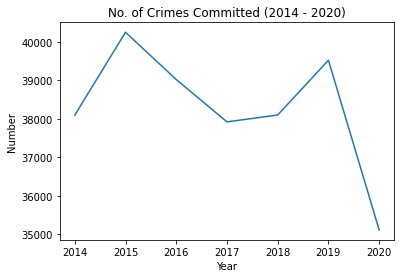

In [39]:
sns.lineplot(data=yoyCrimes[:-1])
plt.xlabel("Year")
plt.ylabel("Number")
plt.title("No. of Crimes Committed (2014 - 2020)")

We can see a serious drop in 2020, which is *more than likely* due to the pandemic. It would be interesting to see how 2020 looks by itself. Let's see:

<AxesSubplot:xlabel='Month', ylabel='Count'>

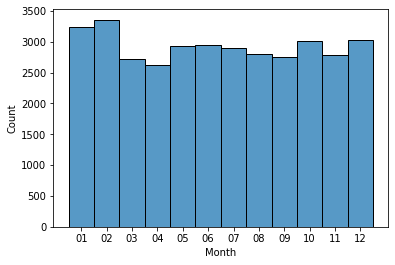

In [40]:
sns.histplot(x='Month', data=crime[crime['Year']==2020])

Not as big of a drop-off as I expected to see for March, seeing as though that's when lockdowns began; however, the drop *is* there and it is significant, with the lowest levels in April, before rising again in May. Crime remained low for the rest of the year as well, spiking slightly in October (Halloween?) and December.

Question: how does 2020 compare with every other year we have on hand?

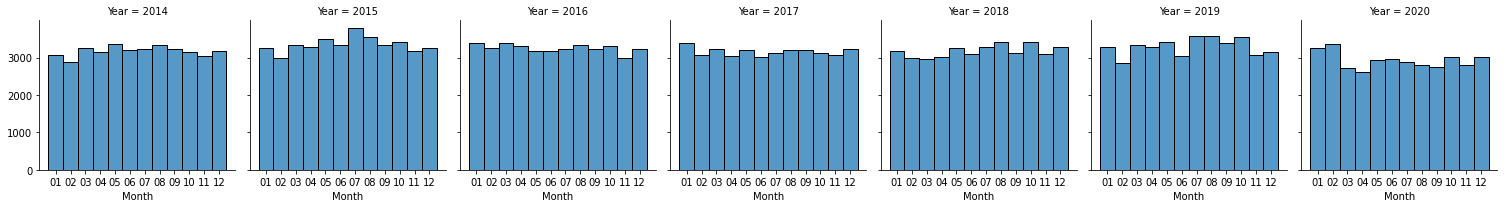

In [41]:
g = sns.FacetGrid(crime[crime['Year']!=2021], col="Year")
g.map(sns.histplot, "Month")

Interestingly, there is no obvious pattern from 2014 - 2019 with respect to the month. There actually seems to be an *increase* in crime between January-February and March-April in 2014, 2015, and 2019; approximately no change in 2016 and 2017; and a small *decrease* in 2018.

That being said, every year looks about constant compared to 2020; lockdowns clearly had a significant effect on the amount of crimes committed, as both March and April of 2020 were clearly historical lows.

To suggest a causal mechanism for this at this point would be opining, but perhaps there's something to be gleaned from looking at the *types* of crimes committed.

---

To start: what are the most commonly committed crimes across all the data we have available? To make it actually readable, let's do the top 10 categories or so.

Text(0.5, 1.0, 'No. of Crimes Committed by Type (2014 - 2021 YTD)')

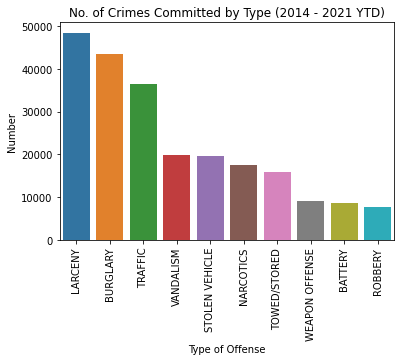

In [42]:
sns.countplot(data=crime, x='Offense_Category', order=crime.Offense_Category.value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.xlabel("Type of Offense")
plt.ylabel("Number")
plt.title("No. of Crimes Committed by Type (2014 - 2021 YTD)")

Far and away, the three most often committed crimes involve theft and traffic violations, with traffic violations at around twice as common as the next most commonly committed type of crime, vandalism.

Now, let's compare the top categories in 2014 - 2019 versus the top categories in 2020:

Text(0.5, 1.0, 'No. of Crimes Committed by Type (2014 - 2019)')

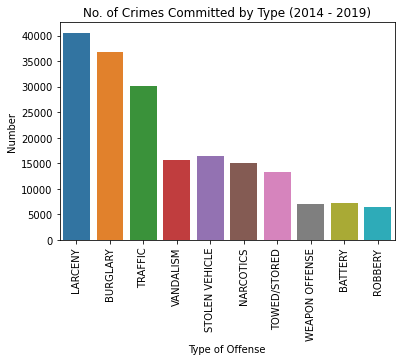

In [43]:
sns.countplot(data=crime[crime['Year']<2020], x='Offense_Category', order=crime.Offense_Category.value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.xlabel("Type of Offense")
plt.ylabel("Number")
plt.title("No. of Crimes Committed by Type (2014 - 2019)")

Text(0.5, 1.0, 'No. of Crimes Committed by Type (2020 - 2021 YTD)')

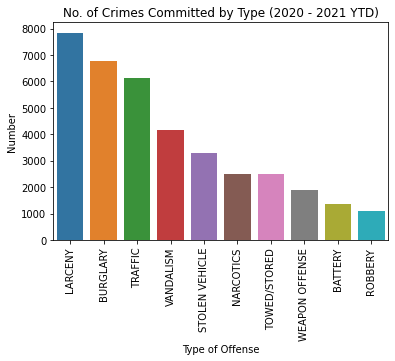

In [44]:
sns.countplot(data=crime[crime['Year']>=2020], x='Offense_Category', order=crime.Offense_Category.value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.xlabel("Type of Offense")
plt.ylabel("Number")
plt.title("No. of Crimes Committed by Type (2020 - 2021 YTD)")

Nope, no change - the types of crimes committed in 2014 - 2019 happened in about the same proportion as they did in 2020 - 2021. The only real change was that vandalism rose in proportion to other crimes; besides that, the distributions look similar. From this, I think it is safe to say that while the pandemic certainly affected the number of crimes committed, it does not seem to have had an effect on the *types* of crimes committed.

---

Now I'd like to look at whether or not the crime is *violent*. To do this, I'm simplifying things a little and considering the following crimes to be "violent crimes": 

Battery; aggravated assault; robbery; sexual offense; assault; and homicide. 

I'll create a column that will be 1 if the crime is violent (contained within these categories), and 0 otherwise.

In [46]:
violent_crimes = ['BATTERY', 'AGG ASSAULT', 'ROBBERY', 'SEXUAL OFFENSE', 'ASSAULT', 'HOMICIDE']

crime['Violent'] = (crime.Offense_Category.isin(violent_crimes)).astype(int)

crime[crime['Violent']==1].sample(10) # Example of some violent crimes.

,Record_ID,Offense_Code,Offense_Category,Description,Police_District,Beat,Grid,Occurence_Date,Date,Time,Year,Month,Day,Violent
18712,1465960,1313,ASSAULT,240 PC ASSAULT/SIMPLE-CIVILIAN,3,3M,0741,2020/07/21 17:37:00+00,2020/07/21,17:37:00+00,2020,07,21,1
5937,1441407,1299,ROBBERY,211 PC ROBBERY-UNSPECIFIED,6,6E,1115,2020/02/28 18:17:00+00,2020/02/28,18:17:00+00,2020,02,28,1
1821,1499154,1315,AGG ASSAULT,245(A)(2) AWDW-FIREARM,6,6A,1031,2021/01/23 03:56:00+00,2021/01/23,03:56:00+00,2021,01,23,1
3724,1009238,1315,AGG ASSAULT,245(A)(2) AWDW-FIREARM,5,5C,1606,2014/02/11 04:41:59,2014/02/11,04:41:59,2014,02,11,1
208,1360342,1313,BATTERY,242 PC BATTERY CIVILIAN,3,3M,0735,2019/01/04 20:30:00+00,2019/01/04,20:30:00+00,2019,01,04,1
3139,1223530,1315,AGG ASSAULT,245(A)(1)AWDW-NON-FIREARM,1,1B,0444,2017/01/31 20:15:00,2017/01/31,20:15:00,2017,01,31,1
23160,1189503,1299,ROBBERY,212.5(A)ROBBERY-INHAB DWELLING,4,4C,1282,2016/08/05 07:06:59,2016/08/05,07:06:59,2016,08,05,1
15961,1176982,1315,AGG ASSAULT,245(A)(1)AWDW-NON-FIREARM,2,2B,0563,2016/05/19 02:32:59,2016/05/19,02:32:59,2016,05,19,1
15518,1033048,1315,AGG ASSAULT,245(A)(1)AWDW-NON-FIREARM,3,3A,0784,2014/06/02 00:10:00,2014/06/02,00:10:00,2014,06,02,1
26222,1195429,1299,ROBBERY,211 PC ROBBERY-UNSPECIFIED,3,3A,0705,2016/09/05 21:24:00,2016/09/05,21:24:00,2016,09,05,1


Now, I wonder: did the pandemic cause any noticeable change in the number of *violent* crimes committed? Again, I'm going to exclude 2021 only because we're looking at levels, and since we only have about 3 months of data, it'll skew the plot.

Text(0.5, 1.0, 'No. of Violent Crimes Committed (2014 - 2020)')

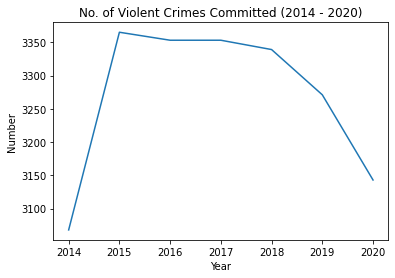

In [47]:
yoyViolentCrimes = crime[crime['Violent']==1]['Year'].value_counts().sort_index(ascending=True)

sns.lineplot(data=yoyViolentCrimes[:-1])
plt.xlabel("Year")
plt.ylabel("Number")
plt.title("No. of Violent Crimes Committed (2014 - 2020)")

Woah! Interesting. Let's put this next to the plot of total crimes:

Text(0.5, 1.0, 'No. of Crimes Committed (2014 - 2020)')

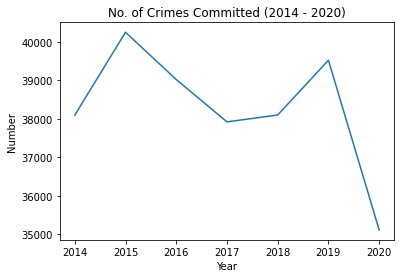

In [48]:
sns.lineplot(data=yoyCrimes[:-1])
plt.xlabel("Year")
plt.ylabel("Number")
plt.title("No. of Crimes Committed (2014 - 2020)")

The spike in crime in 2015 was in part driven by an increase in violent crime; however, since then, violent crime has been on a steady decline in Sacramento (great!). The drop in crime in 2020 was accompanied by a drop in violent crime; it would take some more statistics to analyze whether or not the drop in violent crime was significant compared to the drop in total crime (e.g., was crime more or less violent in 2020, given that *all* crime dropped significantly?).

One way we might begin to answer this is by looking at what *percentage* of crimes each year were violent.

In [49]:
print( (crime[crime['Violent']==1]['Year'].value_counts() / crime['Year'].value_counts()) * 100 )

2014    8.053762
2015    8.360664
2016    8.593249
2017    8.842766
2018    8.764470
2019    8.276612
2020    8.951866
2021    8.853232
Name: Year, dtype: float64


Wow! As it turns out, the annual proportion of violent crimes to total crimes committed is essentially steady between 8 and 9 percent. I'm very surprised at the consistency of this.

We can also see that 2020 was not a good year, actually, as the proportion of violent crimes was highest then than in any previous year. 2021 is seeing a small improvement, but unfortunately is still only second to 2020 in proportion to total crimes committed.